**Problem Statement**

The aim is to implement and evaluate seq2seq mechanism with attention. The models are trained on a synthetic dataset where the target sequence is the reverse of source sequence. We compare this with seq2seq (without attention) to show how attention mechanism effectively improves the seq2seq performance

In [ ]:
!pip install torch torchvision

In [ ]:
# Seq2seq model with attention
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate dummy data
def generate_data(num_samples, seq_len, vocab_size):
    data = []
    for _ in range(num_samples):
        src = [random.randint(1, vocab_size-1) for _ in range(seq_len)]
        tgt = src[::-1]  # Reverse the source sequence for the target
        data.append((src, tgt))
    return data

vocab_size = 20
seq_len = 10
num_samples_train = 10000
num_samples_test = 1000
data_train = generate_data(num_samples_train, seq_len, vocab_size)
data_test = generate_data(num_samples_test, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}



In [ ]:
class Seq2SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src, tgt = self.data[idx]
        return torch.tensor(src, dtype=torch.long), torch.tensor(tgt, dtype=torch.long)

train_dataset = Seq2SeqDataset(data_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = Seq2SeqDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.attn = nn.Linear(hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))

    def forward(self, hidden, encoder_outputs):
        max_len = encoder_outputs.size(1)
        H = hidden.repeat(max_len, 1, 1).transpose(0, 1)
        attn_energies = self.score(H, encoder_outputs)
        return torch.softmax(attn_energies, dim=1).unsqueeze(1)

    def score(self, hidden, encoder_outputs):
        energy = torch.tanh(self.attn(torch.cat([hidden, encoder_outputs], 2)))
        energy = energy.transpose(1, 2)
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)
        energy = torch.bmm(v, energy)
        return energy.squeeze(1)

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(input_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)

    def forward(self, x):
        embedding = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(embedding)
        return outputs, hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, attention):
        super(Decoder, self).__init__()
        self.output_size = output_size
        self.attention = attention
        self.embedding = nn.Embedding(output_size, embed_size)
        self.lstm = nn.LSTM(hidden_size + embed_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden, cell, encoder_outputs):
        x = x.unsqueeze(1)
        embedding = self.embedding(x)
        attn_weights = self.attention(hidden[-1], encoder_outputs)
        context = attn_weights.bmm(encoder_outputs)
        rnn_input = torch.cat((embedding, context), dim=2)
        outputs, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        predictions = self.fc(outputs.squeeze(1))
        return predictions, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_vocab_size = self.decoder.output_size

        outputs = torch.zeros(batch_size, target_len, target_vocab_size).to(device)

        encoder_outputs, hidden, cell = self.encoder(source)

        x = target[:, 0]

        for t in range(1, target_len):
            output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs)
            outputs[:, t, :] = output
            best_guess = output.argmax(1)
            x = target[:, t] if random.random() < teacher_forcing_ratio else best_guess

        return outputs

# Initialize the model
input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, attention).to(device)
model = Seq2Seq(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Epoch [1/15], Loss: 0.1614
Epoch [2/15], Loss: 0.0068
Epoch [3/15], Loss: 0.0039
Epoch [4/15], Loss: 0.0094
Epoch [5/15], Loss: 0.0006
Epoch [6/15], Loss: 0.0076
Epoch [7/15], Loss: 0.0022
Epoch [8/15], Loss: 0.0002
Epoch [9/15], Loss: 0.0001
Epoch [10/15], Loss: 0.0001
Epoch [11/15], Loss: 0.0000
Epoch [12/15], Loss: 0.0000
Epoch [13/15], Loss: 0.0000
Epoch [14/15], Loss: 0.0000
Epoch [15/15], Loss: 0.0000


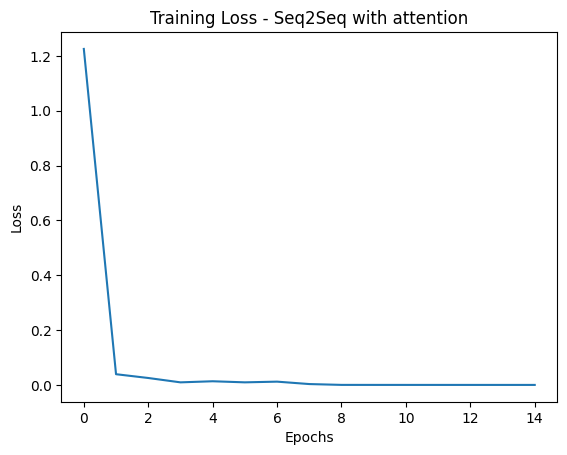

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 15
training_loss = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (src, tgt) in enumerate(train_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    #print(training_loss)

# Plot the Loss
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.title('Training Loss - Seq2Seq with attention')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score
model.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(test_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()
        break
    accuracy = accuracy_score(preds,trues)
    precision = precision_score(preds,trues,average='weighted')
print(f"Accuracy:{accuracy*100 :.2f}%")
print(f"Precison:{precision*100 :.2f}%")

Source: [17  6  8 10  5 18 15 18  4  2]
Target: [ 4 18 15 18  5 10  8  6 17]
Predicted: [ 4 18 15 18  5 10  8  6 17]
Accuracy:100.00%
Precison:100.00%


In [ ]:
# Seq2Seq without attention
# The encoder reads the entire input sequence and converts it single fixed size context vector
# before passing it to the decoder to generate the output.

# While with attention, the attention mechanism allows the decoder to access
# the entire set of hidden states from the encoder at every decoding step.

# At each step of decoding, the model learns to focus on different parts of the input sequence,
# dynamically weighting the importance of each input token based on its relevance to the current output being generated.

In [ ]:
vocab_size = 20
seq_len = 10
num_samples_train = 10000
num_samples_test = 1000
data_train = generate_data(num_samples_train, seq_len, vocab_size)
data_test = generate_data(num_samples_test, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}

train_dataset = Seq2SeqDataset(data_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = Seq2SeqDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
# Encoder
class Encoder_no_att(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, num_layers):
        super(Encoder_no_att, self).__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# Decoder
class Decoder_no_att(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, num_layers):
        super(Decoder_no_att, self).__init__()
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, trg, hidden, cell):
        trg = trg.unsqueeze(1)
        embedded = self.embedding(trg)
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

# Seq2Seq
class Seq2Seq_no_att(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq_no_att, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)

        hidden, cell = self.encoder(src)
        input = trg[:, 0]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t, :] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[:, t] if teacher_force else top1

        return outputs
# Hyperparameters
INPUT_DIM = vocab_size  # Same as vocab size
OUTPUT_DIM = vocab_size  # Same as vocab size
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.001

encoder = Encoder_no_att(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
decoder = Decoder_no_att(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
model_no_att = Seq2Seq_no_att(encoder, decoder, device).to(device)

optimizer = optim.Adam(model_no_att.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Epoch [1/15], Loss: 1.0609
Epoch [2/15], Loss: 0.2661
Epoch [3/15], Loss: 0.0820
Epoch [4/15], Loss: 0.0922
Epoch [5/15], Loss: 0.0086
Epoch [6/15], Loss: 0.0031
Epoch [7/15], Loss: 0.0020
Epoch [8/15], Loss: 0.0013
Epoch [9/15], Loss: 0.0012
Epoch [10/15], Loss: 0.0009
Epoch [11/15], Loss: 0.0007
Epoch [12/15], Loss: 0.0005
Epoch [13/15], Loss: 0.0005
Epoch [14/15], Loss: 0.0003
Epoch [15/15], Loss: 0.0003


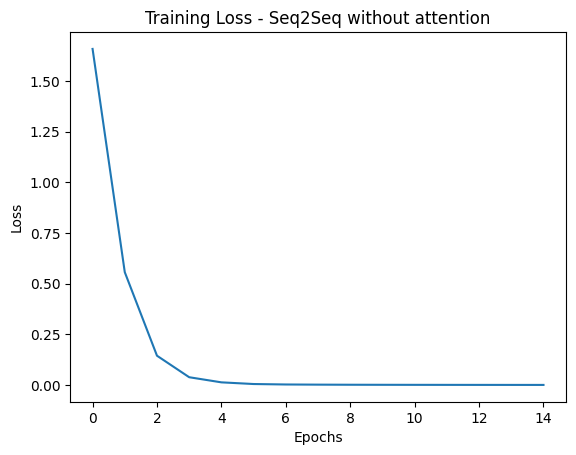

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 15
training_loss = []
for epoch in range(num_epochs):
    model_no_att.train()
    total_loss = 0
    for i, (src, tgt) in enumerate(train_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model_no_att(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model_no_att.parameters(), CLIP)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    #print(training_loss)

# Plot the Loss
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.title('Training Loss - Seq2Seq without attention')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score
model_no_att.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(test_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model_no_att(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()
        break
    accuracy = accuracy_score(preds,trues)
    precision = precision_score(preds,trues,average='weighted')
print(f"Accuracy:{accuracy*100 :.2f}%")
print(f"Precison:{precision*100 :.2f}%")

Source: [ 8  4  6  8  5  9 12 18  7  4]
Target: [ 7 18 12  9  5  8  6  4  8]
Predicted: [ 7 18 12  9  5  8  6  4  8]
Accuracy:100.00%
Precison:100.00%


In [ ]:
# Seq2Seq with attention larger vocabulary size
vocab_size = 1000
seq_len = 50
num_samples_train = 10000
num_samples_test = 1000
data_train = generate_data(num_samples_train, seq_len, vocab_size)
data_test = generate_data(num_samples_test, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}

train_dataset = Seq2SeqDataset(data_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = Seq2SeqDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

input_size = vocab_size
output_size = vocab_size
embed_size = 256
hidden_size = 512
num_layers = 2

attention = Attention(hidden_size)
encoder = Encoder(input_size, embed_size, hidden_size, num_layers).to(device)
decoder = Decoder(output_size, embed_size, hidden_size, num_layers, attention).to(device)
model_big_vocab = Seq2Seq(encoder, decoder).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_big_vocab.parameters(), lr=0.001)

Epoch [1/20], Loss: 6.7909
Epoch [2/20], Loss: 5.7930
Epoch [3/20], Loss: 5.8717
Epoch [4/20], Loss: 4.8691
Epoch [5/20], Loss: 4.4571
Epoch [6/20], Loss: 1.4326
Epoch [7/20], Loss: 6.9098
Epoch [8/20], Loss: 6.8688
Epoch [9/20], Loss: 6.7705
Epoch [10/20], Loss: 6.5722
Epoch [11/20], Loss: 6.0472
Epoch [12/20], Loss: 4.6412
Epoch [13/20], Loss: 1.6659
Epoch [14/20], Loss: 1.2628
Epoch [15/20], Loss: 1.0958
Epoch [16/20], Loss: 0.1821
Epoch [17/20], Loss: 5.8440
Epoch [18/20], Loss: 0.0786
Epoch [19/20], Loss: 0.0347
Epoch [20/20], Loss: 0.0385


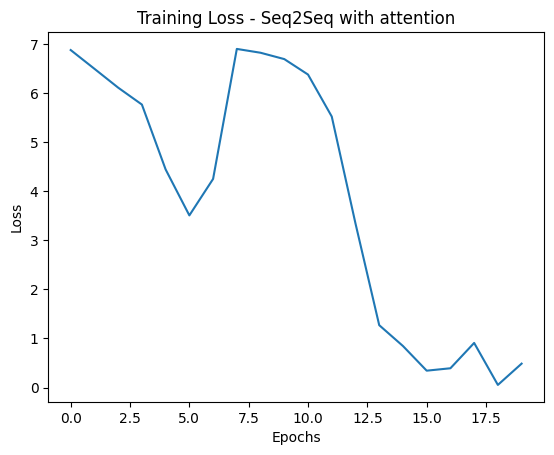

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 20
training_loss = []
for epoch in range(num_epochs):
    model_big_vocab.train()
    total_loss = 0
    for i, (src, tgt) in enumerate(train_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model_big_vocab(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    #print(training_loss)

# Plot the Loss
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.title('Training Loss - Seq2Seq with attention')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score
model_big_vocab.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(test_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model_big_vocab(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()
        break
    accuracy = accuracy_score(preds,trues)
    precision = precision_score(preds,trues,average='micro')
print(f"Accuracy:{accuracy*100 :.2f}%")
print(f"Precison:{precision*100 :.2f}%")

Source: [118 581  31 980 809 783 497 273  19 644 228 249 178 606 428 150 728 283
 135 973 690 713 201 377 214 313  38  51 503 192 809 463 372 804 377  69
 801 996 978 401 308 496 582 567 612 605 473 890 876 959]
Target: [876 890 473 605 612 567 582 496 308 401 978 996 801  69 377 804 372 463
 809 192 503  51  38 313 214 377 201 713 690 973 135 283 728 150 428 606
 178 249 228 644  19 273 497 783 809 980  31 581 118]
Predicted: [876 890 473 605 612 567 582 496 308 401 978 996 801  69 377 804 372 463
 809 192 503  51  38 313 214 377 201 713 690 973 135 283 728 150 428 606
 178 249 228 644  19 273 497 783 809 980  31 581 118]
Accuracy:99.36%
Precison:99.36%


In [ ]:
# Seq2Seq without attention larger vocab size
vocab_size = 1000
seq_len = 50
num_samples_train = 10000
num_samples_test = 1000
data_train = generate_data(num_samples_train, seq_len, vocab_size)
data_test = generate_data(num_samples_test, seq_len, vocab_size)

# Define dummy vocab (for demonstration purposes)
vocab = {str(i): i for i in range(vocab_size)}

train_dataset = Seq2SeqDataset(data_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = Seq2SeqDataset(data_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

INPUT_DIM = vocab_size  # Same as vocab size
OUTPUT_DIM = vocab_size  # Same as vocab size
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HIDDEN_DIM = 256
NUM_LAYERS = 2
LEARNING_RATE = 0.001

encoder = Encoder_no_att(INPUT_DIM, ENC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
decoder = Decoder_no_att(OUTPUT_DIM, DEC_EMB_DIM, HIDDEN_DIM, NUM_LAYERS).to(device)
model_no_att_big_vocab = Seq2Seq_no_att(encoder, decoder, device).to(device)

optimizer = optim.Adam(model_no_att_big_vocab.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Epoch [1/100], Loss: 6.3836
Epoch [2/100], Loss: 6.1822
Epoch [3/100], Loss: 5.9879
Epoch [4/100], Loss: 5.8110
Epoch [5/100], Loss: 5.6668
Epoch [6/100], Loss: 5.5454
Epoch [7/100], Loss: 5.4507
Epoch [8/100], Loss: 5.2835
Epoch [9/100], Loss: 5.1497
Epoch [10/100], Loss: 5.0869
Epoch [11/100], Loss: 4.9674
Epoch [12/100], Loss: 4.9558
Epoch [13/100], Loss: 4.9235
Epoch [14/100], Loss: 4.8195
Epoch [15/100], Loss: 4.7593
Epoch [16/100], Loss: 4.6193
Epoch [17/100], Loss: 4.6491
Epoch [18/100], Loss: 4.6470
Epoch [19/100], Loss: 4.5603
Epoch [20/100], Loss: 4.4702
Epoch [21/100], Loss: 4.4563
Epoch [22/100], Loss: 4.4576
Epoch [23/100], Loss: 4.4457
Epoch [24/100], Loss: 4.3334
Epoch [25/100], Loss: 4.3115
Epoch [26/100], Loss: 4.2248
Epoch [27/100], Loss: 4.2935
Epoch [28/100], Loss: 4.2453
Epoch [29/100], Loss: 4.1968
Epoch [30/100], Loss: 4.2114
Epoch [31/100], Loss: 4.1197
Epoch [32/100], Loss: 4.0991
Epoch [33/100], Loss: 4.0340
Epoch [34/100], Loss: 4.0693
Epoch [35/100], Loss: 3

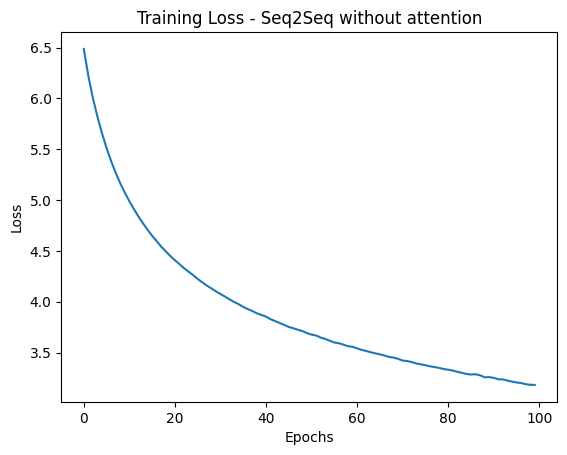

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 100
training_loss = []
for epoch in range(num_epochs):
    model_no_att_big_vocab.train()
    total_loss = 0
    for i, (src, tgt) in enumerate(train_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()
        output = model_no_att_big_vocab(src, tgt)

        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        loss = criterion(output, tgt)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model_no_att.parameters(), 1)
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_dataloader)
    training_loss.append(avg_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    #print(training_loss)

# Plot the Loss
plt.plot(training_loss)
plt.xlabel('Epochs')
plt.title('Training Loss - Seq2Seq without attention')
plt.ylabel('Loss')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score
model_no_att_big_vocab.eval()
with torch.no_grad():
    for i, (src, tgt) in enumerate(test_dataloader):
        src, tgt = src.to(device), tgt.to(device)

        output = model_no_att_big_vocab(src, tgt, teacher_forcing_ratio=0)
        output = output[:, 1:].reshape(-1, output.shape[2])
        tgt = tgt[:, 1:].reshape(-1)

        pred = output.argmax(1).view(-1, seq_len-1)
        print(f'Source: {src[0].cpu().numpy()}')
        print(f'Target: {tgt.view(-1, seq_len-1)[0].cpu().numpy()}')
        print(f'Predicted: {pred[0].cpu().numpy()}')

        preds = output.argmax(1).cpu().numpy()
        trues = tgt.cpu().numpy()
        break
    accuracy = accuracy_score(preds,trues)
    precision = precision_score(preds,trues,average='micro')
print(f"Accuracy:{accuracy*100 :.2f}%")
print(f"Precison:{precision*100 :.2f}%")


Source: [ 78 529 298 208 389 320 552 986 175 828 313 413 412 742 559 405 761 553
 740 113 529   6 655 976 669 547 691 974 609 803  65 186 902 130 376  83
 519 948 240 706 754 110 330  79 281 814 334 965 550 624]
Target: [550 965 334 814 281  79 330 110 754 706 240 948 519  83 376 130 902 186
  65 803 609 974 691 547 669 976 655   6 529 113 740 553 761 405 559 742
 412 413 313 828 175 986 552 320 389 208 298 529  78]
Predicted: [334   9 334 281 281 330 330 330 533 330  51 655 110 706 300 415 658 902
 639  21 572 902 300 608 897 897 897 897 897 289 289 126 126 289 289 289
 423 179 179 278 179  21 179 592 381 465 552 457 492]
Accuracy:3.57%
Precison:3.57%
